**Chapter 17 - Autoencoders, GANs, and Diffusion Models**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >= 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And also TensorFlow >= 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2023-05-17 21:42:37.998190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:42:49.810910: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 21:42:49.810953: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-17 21:42:57.676727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt 

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/generative` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


2023-05-17 21:43:08.035126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-17 21:43:08.038606: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 21:43:08.038726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (avtr): /proc/driver/nvidia/version does not exist


# Performing PCA with an Undercomplete Linear Autoencoder

Building the autoencoder

In [7]:
import tensorflow as tf

tf.random.set_seed(42)          # reproducibility purposes - set seed

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2023-05-17 21:43:08.450284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generare the same 3D dataset used in Chapter 8:

In [8]:
# extra code - builds the same 3D dataset as in Chapter 8

import numpy as np 
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))                                        # initialize 3D dataset
np.random.seed(42)
angles = (np.random.randn(m) ** 3 + 0.5) * 2 * np.pi        # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5     # oval
X += 0.28 * np.random.randn(m, 3)                           # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]                                 # shift a bit

In [9]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


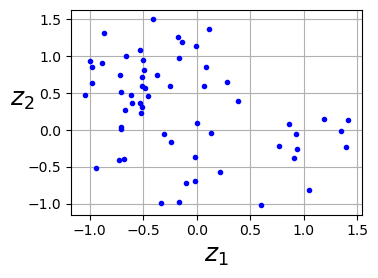

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

## Implementing a Stacked Autoencoder Using Keras

Load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [11]:
# extra code: - loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test       = X_test.astype(np.float32) / 255 

X_train, X_valid = X_train_full[:5000],  X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Building and training a stacked Autoencoder with 3 hidden layers and 1 outut(i.e., 2 stacked Autoencoders).

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
157/157 [==============================] - 5s 11ms/step - loss: 0.0524 - val_loss: 0.0304
Epoch 2/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0268 - val_loss: 0.0253
Epoch 3/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 4/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0226 - val_loss: 0.0225
Epoch 5/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0215 - val_loss: 0.0217
Epoch 6/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0208
Epoch 7/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0201 - val_loss: 0.0203
Epoch 8/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0197 - val_loss: 0.0201
Epoch 9/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0193 - val_loss: 0.0198
Epoch 10/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0190 - val_loss: 0.01

## Visualizing the Reconstructions 

1/1 [==============================] - 0s 139ms/step


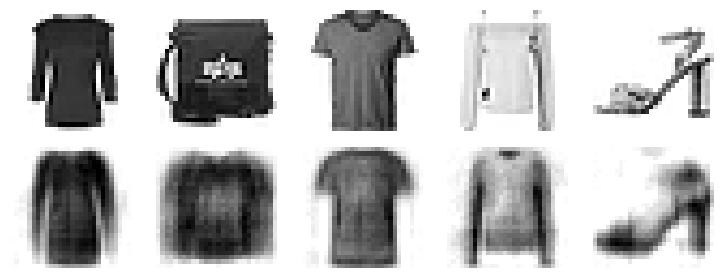

In [13]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

## Visualizing the Fashion MNIST Dataset

In [14]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


/home/bimri/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


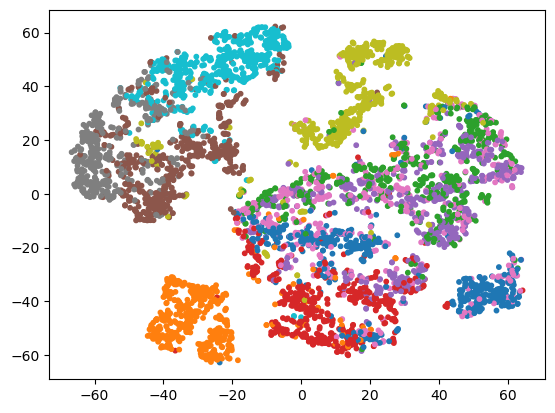

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from [this Scikit-Learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

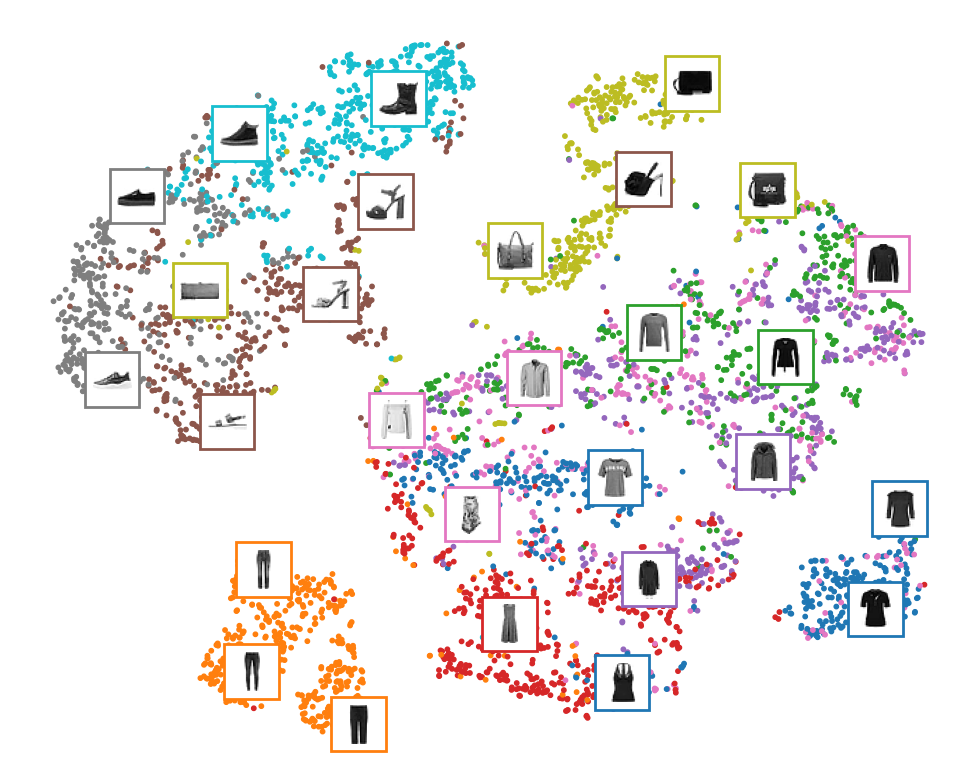

In [16]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [22]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [23]:
tf.random.set_seed(42)              # ensures reproducibility

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
157/157 [==============================] - 6s 15ms/step - loss: 0.0515 - val_loss: 0.0298
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0267 - val_loss: 0.0249
Epoch 3/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0232 - val_loss: 0.0227
Epoch 4/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0213 - val_loss: 0.0210
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0201 - val_loss: 0.0201
Epoch 6/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0193 - val_loss: 0.0192
Epoch 7/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0185 - val_loss: 0.0186
Epoch 8/10
157/157 [==============================] - 2s 15ms/step - loss: 0.0180 - val_loss: 0.0182
Epoch 9/10
157/157 [==============================] - 3s 17ms/step - loss: 0.0175 - val_loss: 0.0179
Epoch 10/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0172 - val_lo

1/1 [==============================] - 0s 116ms/step


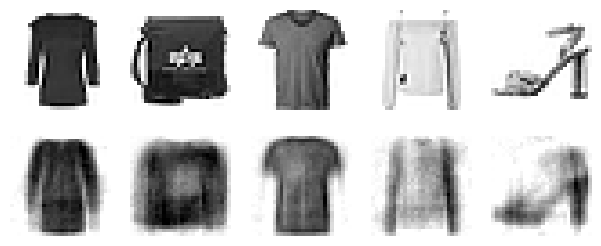

In [24]:
plot_reconstructions(tied_ae)
plt.show()

## Extra Material - Training one Autoencoder at a Time

In [27]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [28]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
157/157 [==============================] - 4s 17ms/step - loss: 0.0509 - val_loss: 0.0282
Epoch 2/10
157/157 [==============================] - 3s 16ms/step - loss: 0.0240 - val_loss: 0.0219
Epoch 3/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0199 - val_loss: 0.0193
Epoch 4/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 5/10
157/157 [==============================] - 5s 29ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 6/10
157/157 [==============================] - 5s 32ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 8/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 9/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0125 - val_loss: 0.0129
Epoch 10/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0120 - val_lo

In [29]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 161ms/step


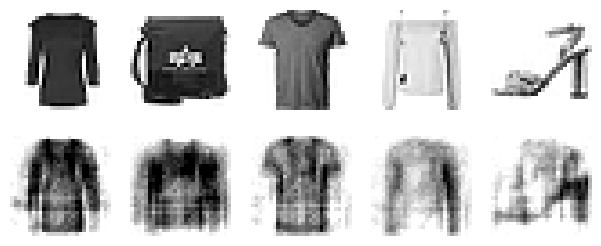

In [30]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [31]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
157/157 [==============================] - 5s 13ms/step - loss: 0.0192 - val_loss: 0.0184
Epoch 2/5
157/157 [==============================] - 2s 12ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 3/5
157/157 [==============================] - 2s 14ms/step - loss: 0.0165 - val_loss: 0.0174
Epoch 4/5
157/157 [==============================] - 2s 13ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 5/5
157/157 [==============================] - 2s 11ms/step - loss: 0.0159 - val_loss: 0.0163


1/1 [==============================] - 0s 160ms/step


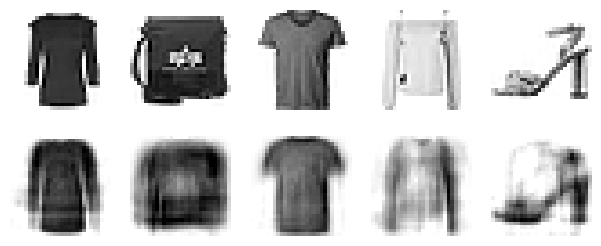

In [32]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [33]:
tf.random.set_seed(42)              # ensures reproducibility  

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
157/157 [==============================] - 19s 79ms/step - loss: 0.0720 - val_loss: 0.0425
Epoch 2/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0358 - val_loss: 0.0324
Epoch 3/10
157/157 [==============================] - 8s 50ms/step - loss: 0.0302 - val_loss: 0.0292
Epoch 4/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0273 - val_loss: 0.0269
Epoch 5/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0255 - val_loss: 0.0251
Epoch 6/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0242 - val_loss: 0.0239
Epoch 7/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0232 - val_loss: 0.0234
Epoch 8/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0224 - val_loss: 0.0225
Epoch 9/10
157/157 [==============================] - 7s 46ms/step - loss: 0.0216 - val_loss: 0.0220
Epoch 10/10
157/157 [==============================] - 7s 44ms/step - loss: 0.0211 - val_l

1/1 [==============================] - 0s 284ms/step


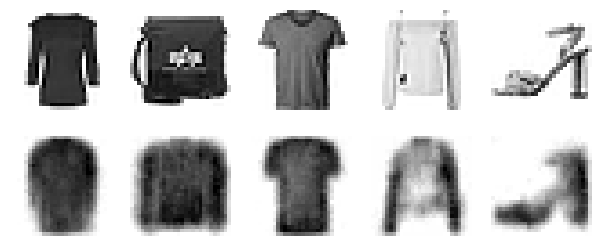

In [34]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

# Extra Material - Recurrent Autoencoders

Let's treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions:

In [35]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [36]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
157/157 [==============================] - 36s 107ms/step - loss: 0.0557 - val_loss: 0.0376
Epoch 2/10
157/157 [==============================] - 14s 92ms/step - loss: 0.0326 - val_loss: 0.0292
Epoch 3/10
157/157 [==============================] - 15s 93ms/step - loss: 0.0274 - val_loss: 0.0334
Epoch 4/10
157/157 [==============================] - 15s 94ms/step - loss: 0.0251 - val_loss: 0.0250
Epoch 5/10
157/157 [==============================] - 15s 94ms/step - loss: 0.0237 - val_loss: 0.0246
Epoch 6/10
157/157 [==============================] - 16s 99ms/step - loss: 0.0227 - val_loss: 0.0238
Epoch 7/10
157/157 [==============================] - 15s 96ms/step - loss: 0.0220 - val_loss: 0.0217
Epoch 8/10
157/157 [==============================] - 15s 98ms/step - loss: 0.0211 - val_loss: 0.0254
Epoch 9/10
157/157 [==============================] - 15s 98ms/step - loss: 0.0206 - val_loss: 0.0269
Epoch 10/10
157/157 [==============================] - 16s 100ms/step - loss: 0.0

1/1 [==============================] - 2s 2s/step


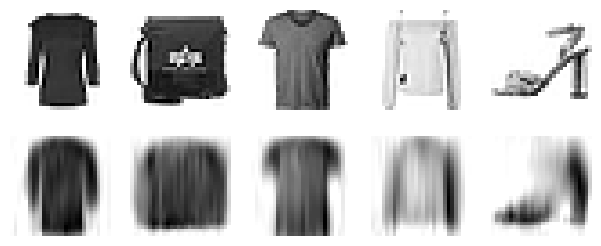

In [37]:
plot_reconstructions(recurrent_ae)
plt.show()

# Denoising Autoencoders

Using ***dropout***:

In [38]:
tf.random.set_seed(42)  # ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
157/157 [==============================] - 7s 22ms/step - loss: 0.0596 - val_loss: 0.0356
Epoch 2/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0324 - val_loss: 0.0283
Epoch 3/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0288 - val_loss: 0.0268
Epoch 4/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0272 - val_loss: 0.0255
Epoch 5/10
157/157 [==============================] - 3s 20ms/step - loss: 0.0261 - val_loss: 0.0245
Epoch 6/10
157/157 [==============================] - 3s 22ms/step - loss: 0.0253 - val_loss: 0.0238
Epoch 7/10
157/157 [==============================] - 3s 17ms/step - loss: 0.0246 - val_loss: 0.0234
Epoch 8/10
157/157 [==============================] - 2s 16ms/step - loss: 0.0241 - val_loss: 0.0227
Epoch 9/10
157/157 [==============================] - 2s 15ms/step - loss: 0.0237 - val_loss: 0.0223
Epoch 10/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0234 - val_lo

1/1 [==============================] - 0s 108ms/step


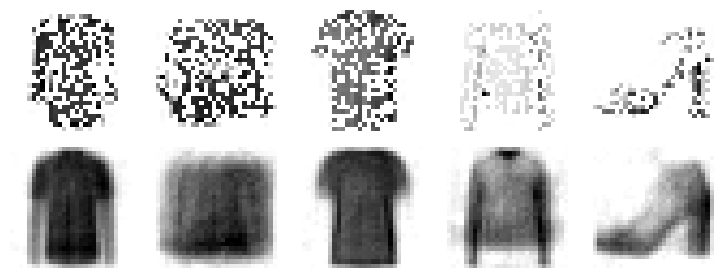

In [39]:
# extra code – this cell generates and saves Figure 17–9
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

If you want, you can try replacing the `Dropout` layer with `tf.keras.layers.GaussianNoise(0.2)`.

# Sparse Autoencoders

Let's use the sigmoid activation function in the coding layer. Let's also add $\ell_1$ regularization to it: to do this, we add an `ActivityRegularization` layer after the coding layer. Alternatively, we could add `activity_regularizer=tf.keras.regularizers.l1(1e-4)` to the coding layer itself.

In [40]:
tf.random.set_seed(42)  # ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
157/157 [==============================] - 7s 21ms/step - loss: 0.0678 - val_loss: 0.0372
Epoch 2/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0326 - val_loss: 0.0304
Epoch 3/10
157/157 [==============================] - 5s 34ms/step - loss: 0.0284 - val_loss: 0.0274
Epoch 4/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0259 - val_loss: 0.0253
Epoch 5/10
157/157 [==============================] - 3s 22ms/step - loss: 0.0242 - val_loss: 0.0239
Epoch 6/10
157/157 [==============================] - 3s 18ms/step - loss: 0.0230 - val_loss: 0.0228
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 0.0218 - val_loss: 0.0221
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0202 - val_loss: 0.0205
Epoch 10/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0196 - val_lo

1/1 [==============================] - 0s 137ms/step


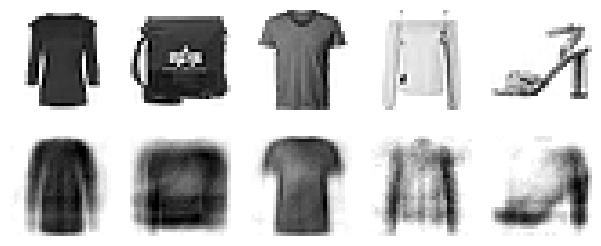

In [41]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()

Let's plot the KL Divergence loss, versus the MAE and MSE:

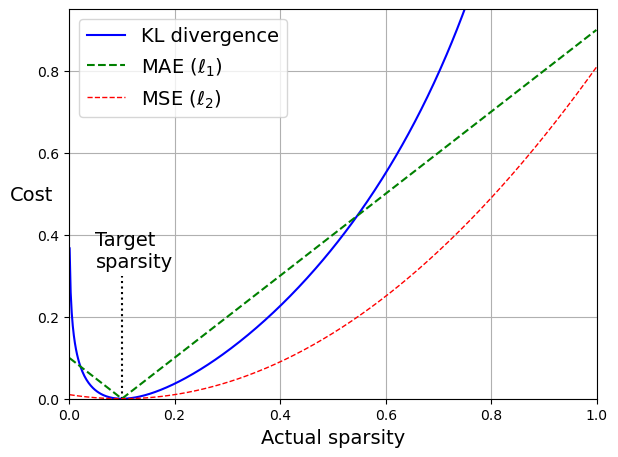

In [42]:
# extra code – this cell generates and saves Figure 17–10
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

Let's define a custom regularizer for KL-Divergence regularization:

In [43]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now let's use this regularizer to push the model to have about 10% sparsity in the coding layer:

In [44]:
tf.random.set_seed(42)  # ensures reproducibility on CPU

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# extra code – compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
157/157 [==============================] - 9s 30ms/step - loss: 0.0641 - val_loss: 0.0364
Epoch 2/10
157/157 [==============================] - 6s 34ms/step - loss: 0.0309 - val_loss: 0.0286
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 4/10
157/157 [==============================] - 2s 16ms/step - loss: 0.0240 - val_loss: 0.0235
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0224 - val_loss: 0.0222
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0212 - val_loss: 0.0212
Epoch 7/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0202 - val_loss: 0.0210
Epoch 8/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0192 - val_loss: 0.0195
Epoch 9/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0185 - val_loss: 0.0187
Epoch 10/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0176 - val_lo

1/1 [==============================] - 0s 137ms/step


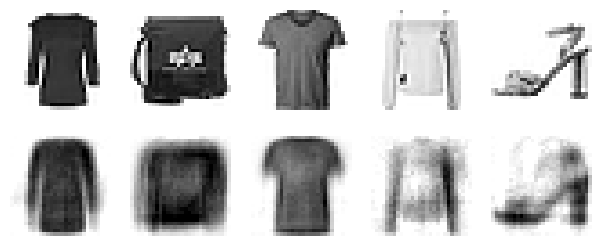

In [45]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_kl_ae)
plt.show()

# Variational Autoencoder

In [46]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [48]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [49]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [50]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [51]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
40/40 [==============================] - 10s 74ms/step - loss: 0.1086 - val_loss: 0.0705
Epoch 2/25
40/40 [==============================] - 3s 70ms/step - loss: 0.0593 - val_loss: 0.0551
Epoch 3/25
40/40 [==============================] - 3s 71ms/step - loss: 0.0520 - val_loss: 0.0516
Epoch 4/25
40/40 [==============================] - 3s 68ms/step - loss: 0.0482 - val_loss: 0.0483
Epoch 5/25
40/40 [==============================] - 2s 61ms/step - loss: 0.0454 - val_loss: 0.0452
Epoch 6/25
40/40 [==============================] - 1s 31ms/step - loss: 0.0428 - val_loss: 0.0423
Epoch 7/25
40/40 [==============================] - 1s 29ms/step - loss: 0.0414 - val_loss: 0.0424
Epoch 8/25
40/40 [==============================] - 1s 33ms/step - loss: 0.0404 - val_loss: 0.0420
Epoch 9/25
40/40 [==============================] - 1s 35ms/step - loss: 0.0397 - val_loss: 0.0420
Epoch 10/25
40/40 [==============================] - 2s 42ms/step - loss: 0.0390 - val_loss: 0.0394
Epoch 11

1/1 [==============================] - 0s 357ms/step


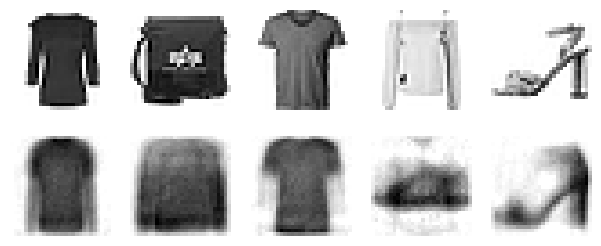

In [52]:
plot_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

Let's generate a few random codings and decode them:

In [53]:
tf.random.set_seed(42)          # ensures reproducibility on CPU

codings = tf.random.normal(shape=[ 3 * 7, codings_size])
images = variational_decoder(codings).numpy()


Plot the images:

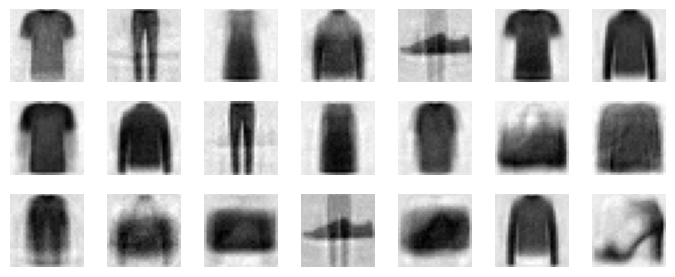

<Figure size 640x480 with 0 Axes>

In [54]:
# extra code - this cells generates and saves Fig. 17-12

def plot_multipl_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_multipl_images(images, 7) 
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

Now let's perform semantic interploation between 2 images:

In [55]:
tf.random.set_seed(42)              # ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)   # axis loooks best in this case
images = variational_decoder(codings).numpy()

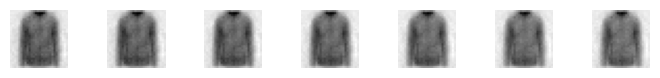

<Figure size 640x480 with 0 Axes>

In [57]:
# extra code - this cell generates and saves Fig. 17-13
plot_multipl_images(images)
save_fig("semantic_interploation_plot", tight_layout=False)
plt.show()